# _**KMeans**_

__<u>KMeans</u>__
- число кластеров	- нужно задать заранее (k)  
- форма кластеров	- чаще всего круглая  
- не умеет (не классифицированные точки относит к кластеру "-1")    
- производительность - быстрее на больших объемах данных  
- чувствительность к параметрам - зависит от выбора числа кластеров   
- применение - хорош для четко разделимых данных

Алгоритм k-средних улавливает понимание того, что каждая точка в кластере должна быть близка к центру этого кластера. Он работает следующим образом: сначала мы выбираем k, количество кластеров, которые мы хотим найти в данных. Затем центры этих k кластеров, называемые центроидами , инициализируются некоторым образом (обсуждается позже).  

Затем алгоритм выполняется в двух чередующихся частях: на этапе Reassign Points мы назначаем каждую точку в данных кластеру, центроид которого находится ближе всего к нему. На этапе Update Centroids мы пересчитываем местоположение каждого центроида как среднее (центр) всех точек, назначенных его кластеру. Затем мы повторяем эти шаги до тех пор, пока центроиды не перестанут двигаться или, что эквивалентно, пока точки не перестанут переключаться между кластерами.  
https://www.naftaliharris.com/blog/visualizing-k-means-clustering/

# <font color='yellow'>-> _pip, import_

#### <font color='yellow'>_Импорты_

In [ ]:
!pip install transformers[sentencepiece]
!pip install huggingface_hub
!pip install tqdm

In [ ]:
!pip install umap-learn

In [1]:
import torch
from sentence_transformers import SentenceTransformer

In [2]:
import sys
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
# Кластеризатор
from sklearn.cluster import KMeans

#### <font color='yellow'>_Работа локально_

In [ ]:
!pip install python-dotenv

In [ ]:
import os
from dotenv import load_dotenv

# Проверка наличия токена в env
load_dotenv()
print(os.getenv("HF_TOKEN"))

# Использования токена:
from huggingface_hub import login
login(os.getenv("HF_TOKEN"))

# Подключение файла classifiers_functions.py (классификаторы и ф-ция оценки качества классификации)
sys.path.append('./Classifiers')
import classifiers_functions

#### <font color='yellow'>_Работа на Google Colab_

In [3]:
from huggingface_hub import notebook_login
notebook_login()

In [4]:
# Связь с файлами на Google drıve
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# !touch "/content/drive/My Drive/Example_ML/classification_text/Classifiers/Classifiers/__init__.py"
sys.path.append('/content/drive/My Drive/Example_ML/classification_text/Classifiers/Classifiers/')
print(sys.path)
# Подключение файла classifiers_functions.py (классификаторы и ф-ция оценки качества классификации)
import classifiers_functions

['/content', '/env/python', '/usr/lib/python311.zip', '/usr/lib/python3.11', '/usr/lib/python3.11/lib-dynload', '', '/usr/local/lib/python3.11/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.11/dist-packages/IPython/extensions', '/root/.ipython', '/usr/local/lib/python3.11/dist-packages/setuptools/_vendor', '/tmp/tmpbbhj_5vb', '/content/drive/My Drive/Example_ML/classification_text/Classifiers/Classifiers/']


# <font color='yellow'>_-> эмбеддинг данных_   

### _собственно эмбеддинг_

In [ ]:
# === Загрузка модели (перевод на CUDA, если возможно) ===
model_name = "cointegrated/rubert-tiny2"  # Можно RuBERT
# model_name = "sentence-transformers/LaBSE"  # Можно RuBERT
device = "cuda" if torch.cuda.is_available() else "cpu"
model = SentenceTransformer(model_name).to(device)

In [ ]:
# === Параметры для загрузки текста ===
chunk_size = 1000
file_path_data = '/content/drive/My Drive/Example_ML/classification_text/Classifiers/articles.csv'

In [ ]:
# Читаем первый chunk и смотрим полученные данные
chunk = next(pd.read_csv(file_path_data, chunksize=chunk_size))  # Загружаем первый кусок
print(chunk.head())  # Вывод первых строк
print(chunk.columns)  # Вывод всех колонок в файле

   doc_id                                              title
0       6  Заместитель председателяnправительства РФnСерг...
1    4896  Матч 1/16 финала Кубка России по футболу был п...
2    4897  Форвард «Авангарда» Томаш Заборский прокоммент...
3    4898  Главный тренер «Кубани» Юрий Красножан прокомм...
4    4899  Решением попечительского совета владивостокско...
Index(['doc_id', 'title'], dtype='object')


In [ ]:
# Видим, что текст  в колонке `title`, добавляем параметр
text_column = "title"  # Название колонки с текстами

In [ ]:
# Выполняем одновременно:
# - чтение текстов из файла (до заданного к-ва)
# - их эмбеддинг

all_texts = []
embeddings_list = []
all_clusters = []  # Сюда будем добавлять номера кластеров

max_text = 5000 # maximum number of texts
current_count = 0

# Загружаем данные по частям (количеством текстов = max_text) и выполняем эмбеддинг

# ____________ tqdm — это Python-библиотека, которая добавляет прогресс-бар при выполнении цикла. Название происходит от арабского "taqaddum" — «прогресс».
# ____________ показывает: текущий прогресс (в процентах), количество итераций, время выполнения, ETA (оценку оставшегося времени), скорость обработки.

for chunk in tqdm(pd.read_csv(file_path_data, chunksize=chunk_size), desc="Обработка данных"):

    if text_column not in chunk.columns:
        print(f"Ошибка: в CSV нет колонки '{text_column}'. Доступные: {chunk.columns}")
        break

    texts = chunk[text_column].dropna().tolist()  # Убираем пустые значения

    remaining = max_text - current_count
    if remaining <= 0:
        break
    # Обрезаем чанк, если он превышает лимит
    if len(texts) > remaining:
        texts = texts[:remaining]

    embeddings_chunk = model.encode(texts, convert_to_numpy=True, show_progress_bar=True)  # Эмбеддинг текстов

    # Добавляем эмбеддинги и тексты в общий список
    all_texts.extend(texts) # Сохраняем тексты
    embeddings_list.append(embeddings_chunk)

    current_count += len(texts)
    if current_count >= max_text:
        break

# === Объединяем все эмбеддинги ===
embeddings = np.vstack(embeddings_list)  # Превращаем список батчей в одну матрицу

### _проверка на нормализованность_

При классификации эмбеддингов, в которых схожесть объектов определяется косинусным расстоянием, в классификаторах лучше использовать косинусную метрику вместо евклидовой. Но, если эмбеддинги уже нормализованы (единичная длина), то минимизация евклидового расстояния эквивалентна минимизации косинусного расстояния, так как:  
$$
\text{cosine distance} = 1 - \cos(\theta) = 1 - \frac{A \cdot B}{\|A\| \|B\|}
$$  
При ∥𝐴∥ = ∥𝐵∥ = 1 , минимизация евклидова расстояния  ∥A−B∥ будет приводить к той же кластеризации, что и минимизация косинусного расстояния.

Проверка

In [ ]:
# import numpy as np
norms = np.linalg.norm(embeddings, axis=1) # Вычислим нормы всех эмбеддингов

print(f"Min norm: {np.min(norms)}")
print(f"Max norm: {np.max(norms)}")
print(f"Mean norm: {np.mean(norms)}")

Min norm: 0.9999998807907104
Max norm: 1.0000001192092896
Mean norm: 1.0


Если нет, можно их нормализовать вручную

In [ ]:
from sklearn.preprocessing import normalize
normalized_embeddings = normalize(embeddings, norm="l2")

### _сохранение эмбеддингов_

In [ ]:
file_path_embeddings = f'/content/drive/My Drive/Example_ML/classification_text/Classifiers/Data/embeddings_rubert-tiny2_text_{max_text}.npy'  # Путь к файлу для сохранения эмбеддингов
np.save(file_path_embeddings, embeddings)  # Сохраняем эмбеддинги в файл
print(f"✅ Обработано {len(embeddings)} текстов. Эмбеддинги сохранены в {file_path_embeddings}")

✅ Обработано 5000 текстов. Эмбеддинги сохранены в /content/drive/My Drive/Example_ML/classification_text/Classifiers/Data/embeddings_rubert-tiny2_text_5000.npy


In [ ]:
print(type(embeddings))
print(embeddings.shape)

<class 'numpy.ndarray'>
(5000, 312)


# <font color='lightblue'>-> _кластеризация по сохраненным эмбеддингам_

### _загрузка текстов и их эмбеддингов <font color='orange'><small>(all_texts, ebeddings)_  

In [ ]:
# Если не было ранее подключение в google drive
from google.colab import drive
drive.mount('/content/drive')

In [6]:
# Загрузка текстов

# _______ Параметры ______________
chunk_size = 1000 # # Размер чанка при загрузке текстов
# Google Colab
file_path_data = '/content/drive/My Drive/Example_ML/classification_text/Classifiers/articles.csv'
# Локально
# file_path_data = 'articles.csv'
text_column = "title"  # Название колонки с текстами

# _________ Загрузка _______________________

all_texts = []
max_text = 5000 # maximum number of texts !!! Используется в названии файла !!!
current_count = 0

for chunk in tqdm(pd.read_csv(file_path_data, chunksize=chunk_size), desc="Обработка данных"):
    if text_column not in chunk.columns:
        print(f"Ошибка: в CSV нет колонки '{text_column}'. Доступные: {chunk.columns}")
        break

    texts = chunk[text_column].dropna().tolist()  # Убираем пустые значения

    remaining = max_text - current_count
    if remaining <= 0:
        break
    # Обрезаем чанк, если он превышает лимит
    if len(texts) > remaining:
        texts = texts[:remaining]
    all_texts.extend(texts)  # Объединяем части текста вместе

    current_count += len(texts)
    if current_count >= max_text:
        break

len(all_texts) # list

Обработка данных: 4it [00:00,  8.71it/s]


5000

In [7]:
# Загрузка эмбеддингов

# _________ Параметры ____________
batch_size = 10000  # Размер батча

# Google Colab
file_path_embeddings = f'/content/drive/My Drive/Example_ML/classification_text/Classifiers/Data/embeddings_rubert-tiny2_text_{max_text}.npy'  # Путь к файлу эмбеддингов
# Локально
# file_path_embeddings = './Data/embeddings_rubert-tiny2.npy'  # Файл с эмбеддингами

# _________ Загрузка _______________________
# Загружаем файл в режиме "чтение без загрузки в память"
embeddings_mmap = np.load(file_path_embeddings, mmap_mode="r")

num_samples = embeddings_mmap.shape[0] # Определяем количество примеров (должно быть = max_text)
all_embeddings = [] # Пустой список для хранения частей эмбеддингов

# Читаем файл частями
for i in range(0, num_samples, batch_size):
    batch = embeddings_mmap[i : i + batch_size]  # Загружаем батч
    all_embeddings.append(batch)  # Добавляем в список

embeddings = np.vstack(all_embeddings) # Объединяем все части в один массив NumPy

print(f"Форма объединённого массива: {embeddings.shape}") # Проверяем размер итогового массива

Форма объединённого массива: (5000, 312)


### _анализ данных_ <font color='orange'><small>(дендрограмма, среднее расстояние между точками, проверка эмбеддингов (нормализация)</small>).

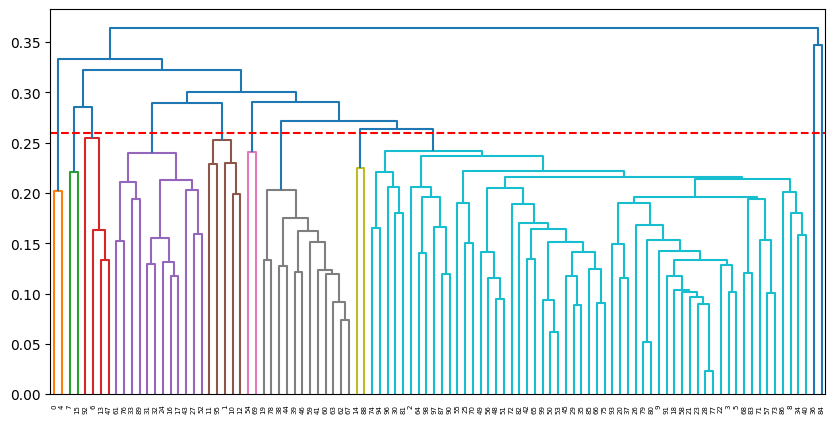

In [ ]:
# _________Построением дендрограммы_________
# 📌 Позволяет прикинуть, на сколько классов целесообразно разбить данные.
import scipy.cluster.hierarchy as sch

plt.figure(figsize=(10, 5))
sch.dendrogram(sch.linkage(embeddings[:100], method='average', metric='cosine'))

# Добавляем горизонтальную линию на уровне ...
plt.axhline(y=0.26, color='r', linestyle='--')  # Порог для разбиения

plt.show()

In [ ]:
# _________Среднее расстояние между точками.___________
# 📌 Для DBSCAN это дает ориентир для выбора значения `eps` - параметра окна, в котором подсчитывается число "соседних" точек.
from sklearn.neighbors import NearestNeighbors

neighbors = NearestNeighbors(n_neighbors=5) #  ищем 5 ближайших соседей для каждой точки.
neighbors.fit(embeddings)                   #  "запоминаем" точки эмбеддингов в алгоритме ближайших соседей.
#  вычисляем расстояния до n_neighbors ближайших точек.
distances, _ = neighbors.kneighbors(embeddings)
avg_distance = np.mean(distances[:, -1])  # Среднее расстояние до 5-го соседа
print(f"Среднее расстояние между точками: {avg_distance:.4f}")
# Среднее расстояние между точками: 0.4798

Среднее расстояние между точками: 0.5162


<small>Что делает `distances, _ = neighbors.kneighbors(embeddings)`  
В distances[i, j] хранится расстояние от i-го эмбеддинга текста до его j-го ближайшего соседа. Пример: distances[:]  
```
array([
    [0.00, 0.32, 0.45, 0.51, 0.67],  # 5 соседей для 1-го эмбеддинга текста
    [0.00, 0.28, 0.41, 0.55, 0.70],  # 5 соседей для 2-го эмбеддингатекста
    ...
    [0.00, 0.30, 0.49, 0.60, 0.80]   # 5 соседей для 27000-го эмбеддинга текста
])
```
distances[i, -1] — расстояние до самого дальнего из 5 соседей.</small>

In [ ]:
# Нормализация эмбеддингов (проверка)
norms = np.linalg.norm(embeddings, axis=1) # Вычислим нормы всех эмбеддингов

print(f"Min norm: {np.min(norms)}")
print(f"Max norm: {np.max(norms)}")
print(f"Mean norm: {np.mean(norms)}")

### _подбор к-ва классов по методу "локтя"_

In [ ]:
# Выбор оптимального к-во классов по методу локтя
ssd = []

start = 4
finish = 12

for n_class in range(start, finish):
    model_test = KMeans(n_class, random_state=42, n_init=11)
    model_test.fit(embeddings)
    ssd.append(model_test.inertia_) # Сумма квадратов расстяний от точек до центров кластеров
pd.DataFrame(data=zip(range(start, finish), pd.Series(ssd).diff()), columns=["k", "diff"])

,k,diff
0,4,NaN
1,5,-36.666138
2,6,-22.379395
3,7,-18.052124
4,8,-14.279663
5,9,-13.361572
6,10,-11.712280
7,11,-10.299683


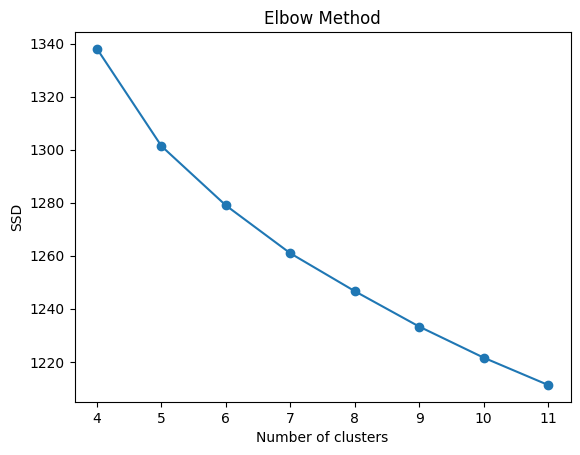

In [ ]:
import matplotlib.pyplot as plt
plt.plot(range(4, 12), ssd, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSD')
plt.title('Elbow Method')
plt.show()

### _кластеризация_

In [8]:
# Кластеризация KMeans
num_clusters = 10 # См., что показал метод локтя

kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=20)
clusters = kmeans.fit_predict(embeddings) # fit_predict сразу выполняет обучение (fit) + предсказание (predict) кластеров.

print(f"✅ Форма clusters - {clusters.shape}")
print(f"✅ Количество clusters - {len(set(clusters))}.")
# print(clusters_KMeans_short)

✅ Форма clusters - (5000,)
✅ Количество clusters - 10.


In [9]:
# Количественное распределение текстов по кластерам:
from collections import Counter
counts_cluster = Counter(clusters)
counts_cluster

Counter({np.int32(8): 542,
         np.int32(7): 440,
         np.int32(3): 961,
         np.int32(6): 600,
         np.int32(5): 412,
         np.int32(1): 535,
         np.int32(4): 492,
         np.int32(0): 246,
         np.int32(9): 368,
         np.int32(2): 404})

In [10]:
# Формируем датафрейм их текстов, их эмбеддингов и меток
df = pd.DataFrame({"text": all_texts, "embedding": list(embeddings), "cluster": list(clusters)})
df.head()

,text,embedding,cluster
0,Заместитель председателяnправительства РФnСерг...,"[0.07518719, -0.0055617844, 0.014240301, -0.04...",8
1,Матч 1/16 финала Кубка России по футболу был п...,"[0.00035189706, -0.04810312, -0.020328153, -0....",7
2,Форвард «Авангарда» Томаш Заборский прокоммент...,"[0.04424202, 0.00478189, -0.02290487, -0.04921...",3
3,Главный тренер «Кубани» Юрий Красножан прокомм...,"[0.047330584, 0.031060353, 0.0015447184, -0.03...",3
4,Решением попечительского совета владивостокско...,"[0.07092083, -0.05181958, -0.01780495, -0.0265...",8


In [ ]:
# Просмотр релевантности текстов в кластерах определенным темам
claster_number = 0 # Выбор номера кластера
df_filtered =  df[df["cluster"] == claster_number] # Фильтруем строки
print(df_filtered['text'].head(10)) # Выводим первые 10 строк

991     Трагически закончился матч любительских футбол...
1132    Спортсмен одной из зарубежных сборных, прибывш...
2803    Российско-израильский предприниматель Аркадий ...
3004    Более 10 тысяч человек пришли проститься с одн...
3007    Прошедшая среда стала рекордным по количеству ...
3031    В США арестован предполагаемый создатель сканд...
3038    В столице Крыма Симферополе представители крым...
3053    Вооруженные силы Африканского союза штурмуют п...
3059    Сирийские власти разослали абонентам мобильной...
3063    Два сторонника оппозиции были убиты в субботу ...
Name: text, dtype: object


### _сохранение (тексты, эмбеддинги, метки)_

In [11]:
# Google Colab
output_file = f'/content/drive/My Drive/Example_ML/classification_text/Classifiers/Experiments/After_clastering/clusters_rubert-tiny2_KMeans_{max_text}.csv'
# Локально
# output_file = f"./Data/clusters_rubert-tiny2_KMeans_{max_text}.csv"

df.to_csv(output_file, index=False, encoding="utf-8")
print(f"✅ Кластеры сохранены в {output_file}.")

✅ Кластеры сохранены в /content/drive/My Drive/Example_ML/classification_text/Classifiers/Experiments/After_clastering/clusters_rubert-tiny2_KMeans_5000.csv.
